In [69]:
# Import all libraries
import pandas as pd
import numpy as np
import sqlite3
import quandl as quandl
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.linear_model import Ridge
from sklearn.preprocessing import PolynomialFeatures

In [70]:
# Create a SQL connection to our SQLite database
con = sqlite3.connect("/Users/william/Desktop/ESCP/Markets/VBAPython/Python Project/escp_msf_exercise.sqlite")
cur = con.cursor()
# Make a query to download all data from SQL file
data = pd.read_sql_query('SELECT * FROM "data"', con=con)
df_variables = pd.read_sql_query('SELECT * FROM "variables_reference"', con=con)
# Display the dataset from the SQL file
print(df_variables)
# Creation of a dictionary
data_dict = dict(zip(df_variables["id_variable"], df_variables["variable"]))
# Mapping of all variables ID to their reference
data["id_variable"] = data["id_variable"].map(data_dict)
data = data.pivot(index="date", columns="id_variable", values="value")

   id_variable                       variable
0            1  coffee_total_consumption_usda
1            2         china_gdp_yoy_forecast
2            3                   sugar_nearby
3            4                   crude_nearby
4            5                  coffee_nearby
5            6                      vix_index
6            7        colombia_coffee_exports
7            8    non_commercial_net_position
8            9               coffee_inventory


In [71]:
# Open & download all data from dxy file on the dataframe data_dxy
f = open("/Users/william/Desktop/ESCP/Markets/VBAPython/Python Project/dxy", "r")
data_dxy = pd.read_csv("/Users/william/Desktop/ESCP/Markets/VBAPython/Python Project/dxy", index_col=0)
liste = []
# Reshaping data format 
for i in range(data_dxy.shape[0]):
    var = data_dxy.index[i].split(' ')
    liste.append(var[0])
    
# Add dxy to our current dataframe and rename the column 
data_dxy.index = liste
data_dxy.columns = ['dxy']
data_dxy = data.assign(dxy=data_dxy['dxy'])

In [72]:
# Now we are downloading data from Quandl for China GDP and T Yield - we take only the 10Y
quandl.ApiConfig.api_key ="9fSgSHKV4RkTirw_Dc-P"

# Creation of datafrme China_GDP
China_GDP = quandl.get('ODA/CHN_NGDPDPC')

# Creation of datafrme T_yield
treasury_yield = quandl.get('USTREASURY/YIELD')

# We assign all our preivous data to the new one China_GDP
df = data_dxy.assign(China_GDP=China_GDP['Value'])

# We assign all our preivous data to the new one T_yield
df = df.assign(treasury_yield=treasury_yield['10 YR'])

# We want to see what's inside our new dataframe
print(df)

id_variable  china_gdp_yoy_forecast  coffee_inventory  coffee_nearby  \
date                                                                   
1990-01-02                      NaN               NaN          80.56   
1990-01-03                      NaN               NaN          81.75   
1990-01-04                      NaN               NaN          82.48   
1990-01-05                      NaN               NaN          81.16   
1990-01-08                      NaN               NaN          81.38   
...                             ...               ...            ...   
2020-02-05                      5.8         2166495.0          97.75   
2020-02-06                      5.8         2166185.0          98.15   
2020-02-07                      5.8         2164799.0          98.35   
2020-02-10                      5.8         2166601.0         100.30   
2020-02-11                      5.8               NaN            NaN   

id_variable  coffee_total_consumption_usda  colombia_coffee_exp

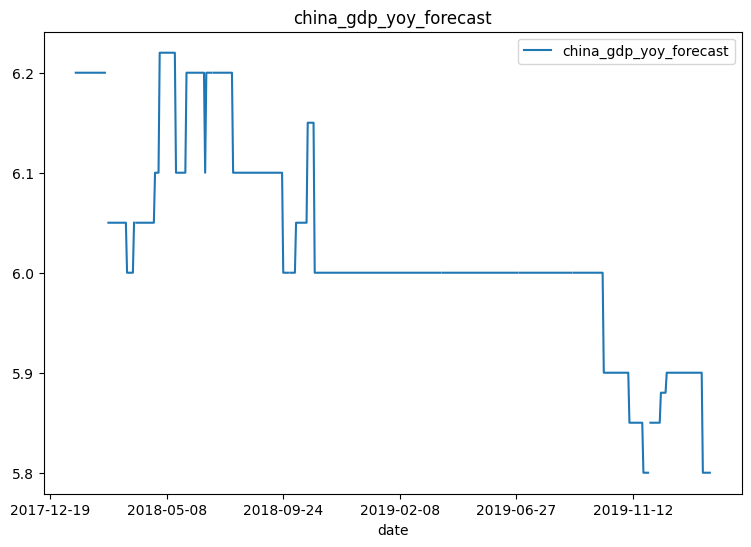

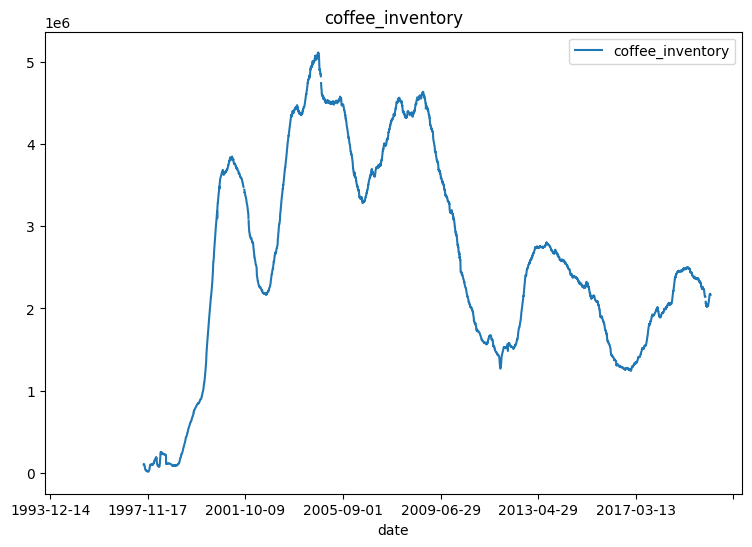

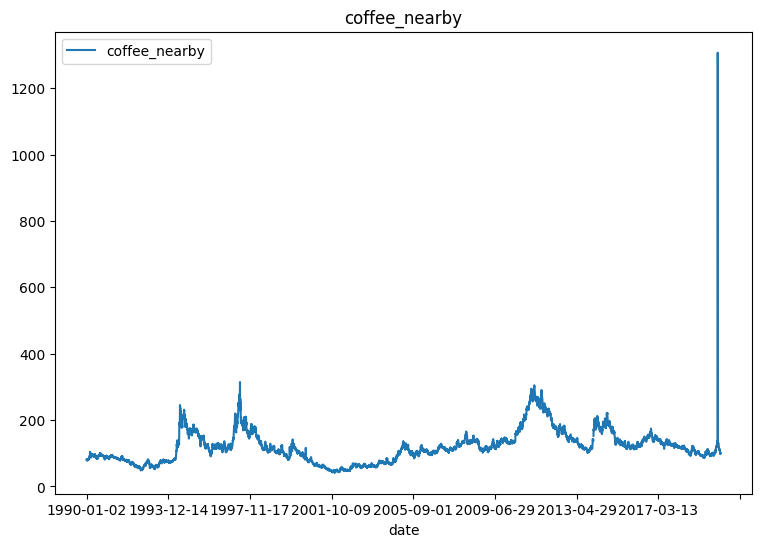

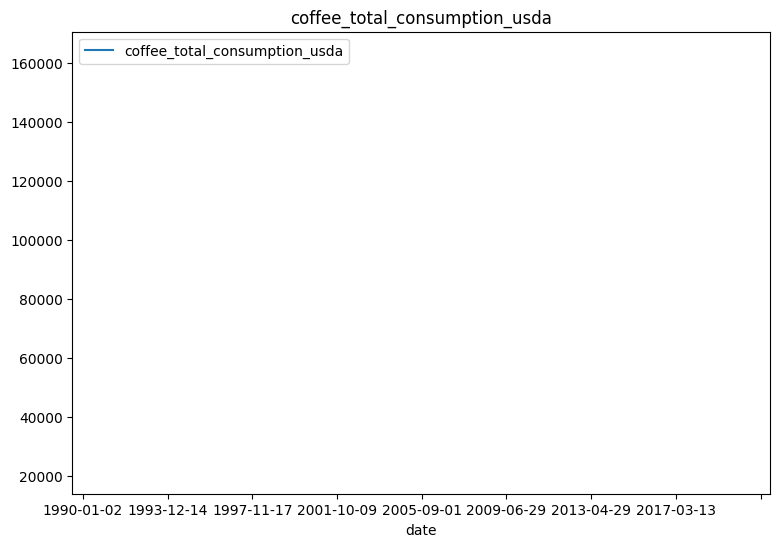

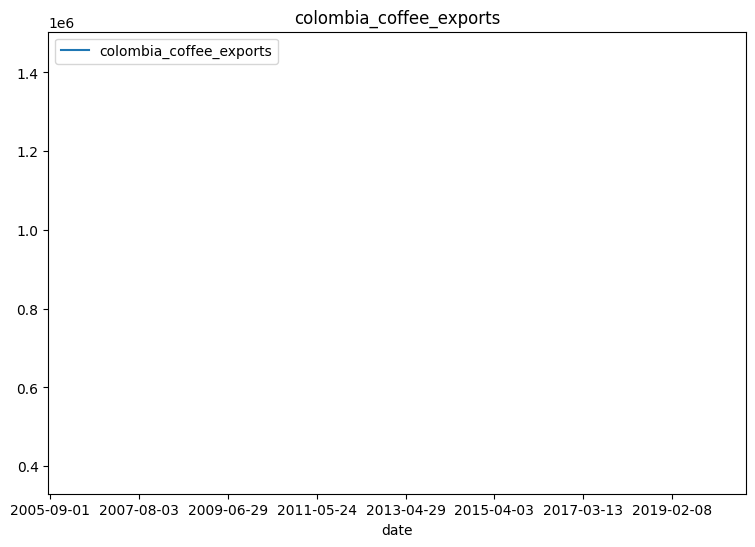

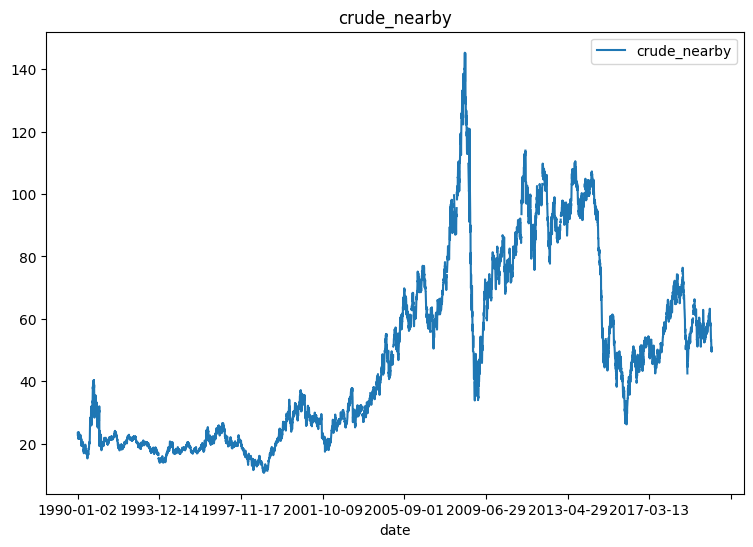

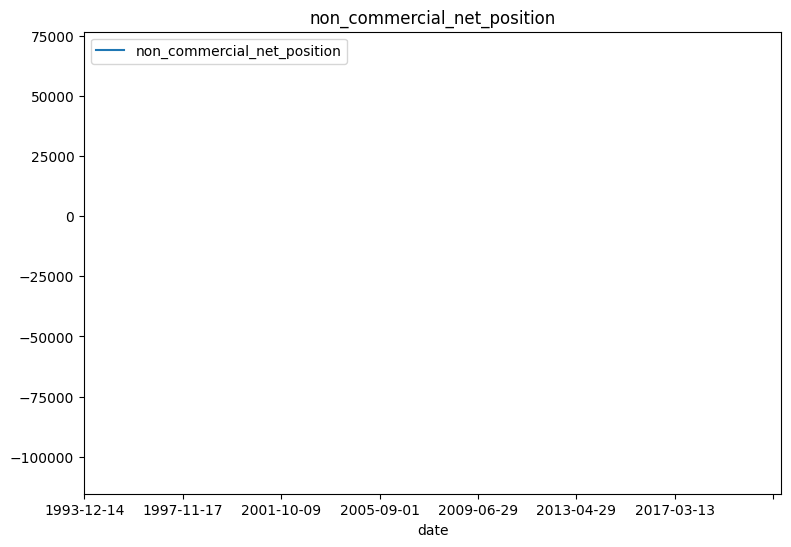

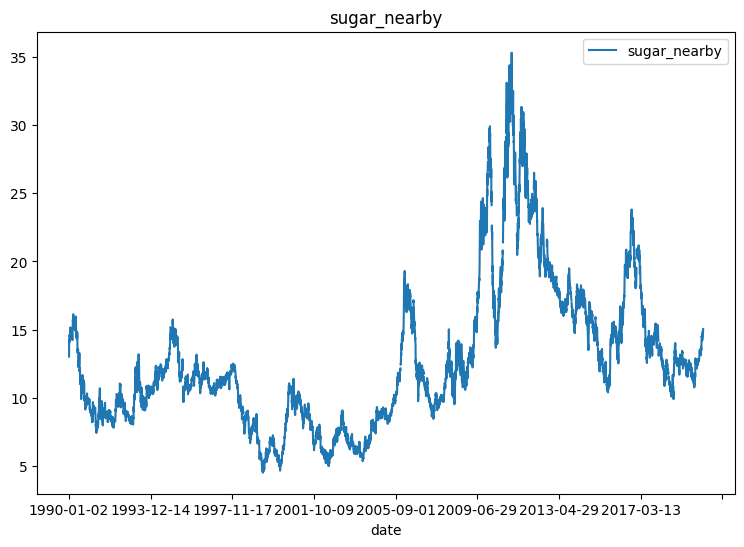

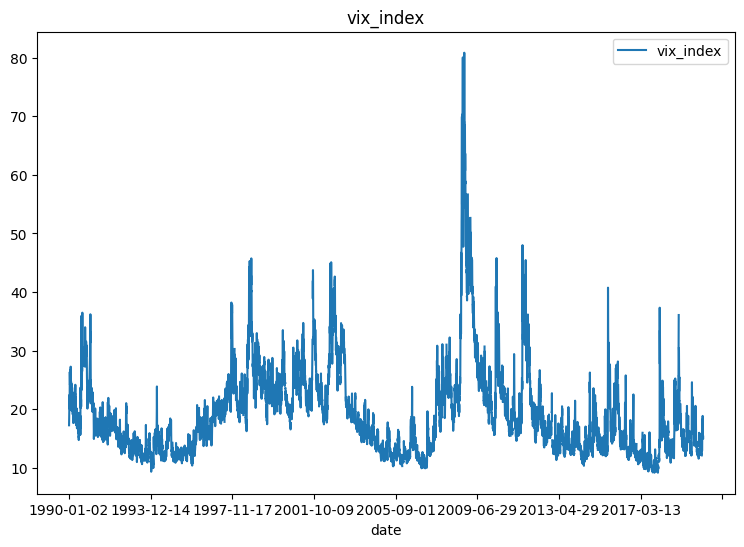

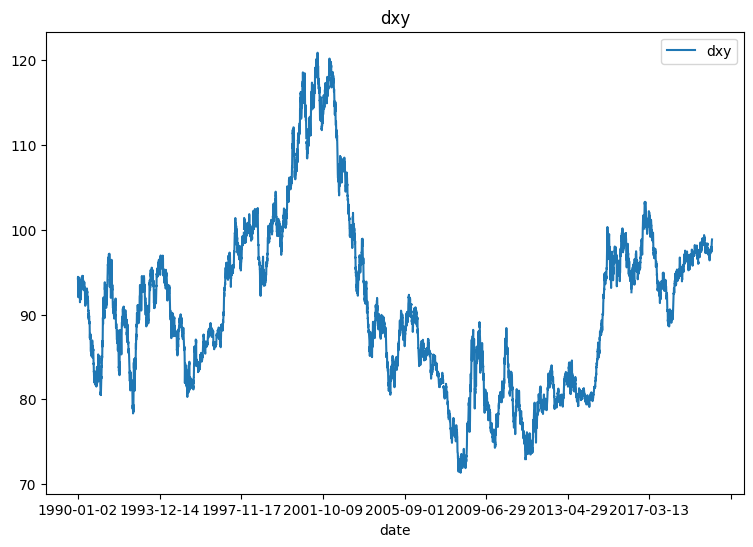

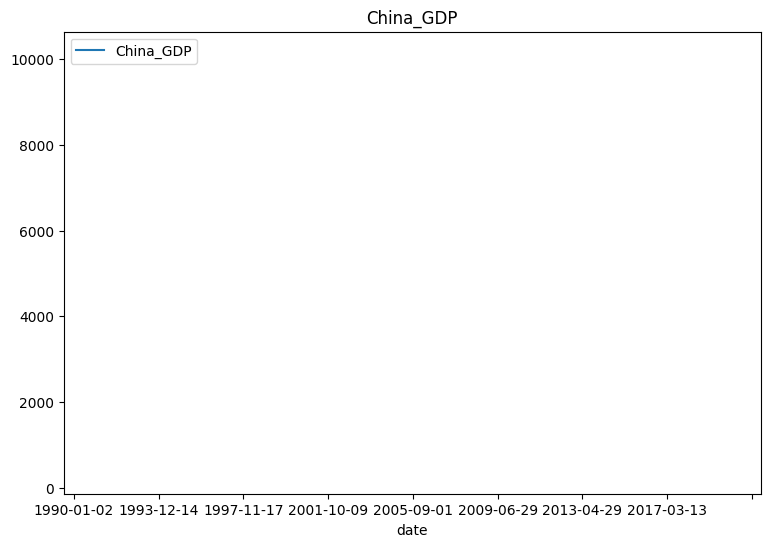

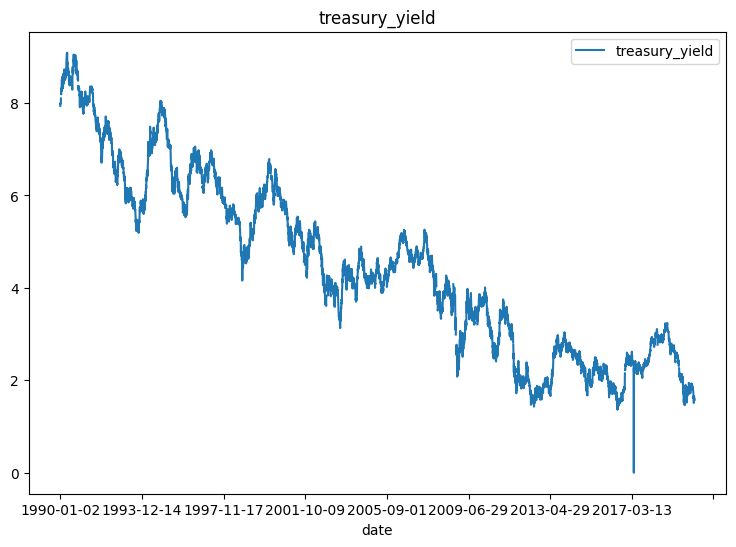

In [73]:
# We now want to visualize all graph 
for col in df.columns:
    df.plot(y=col, figsize=(9,6))
    plt.title(col)
    plt.show()

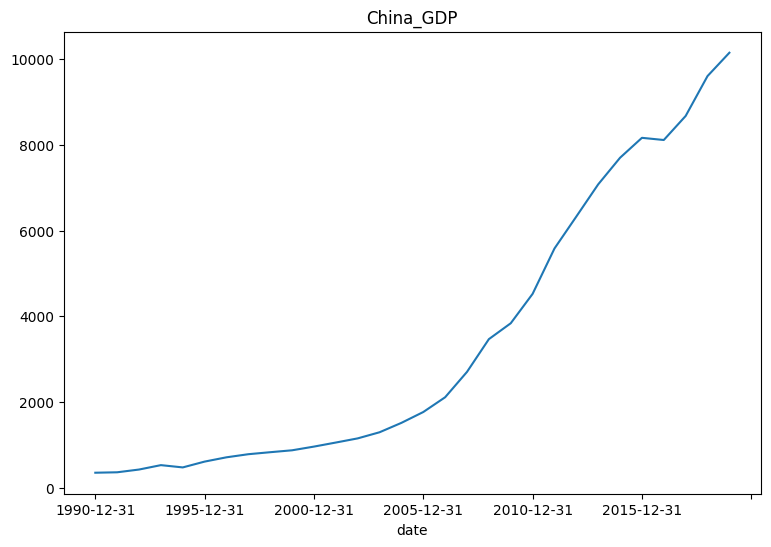

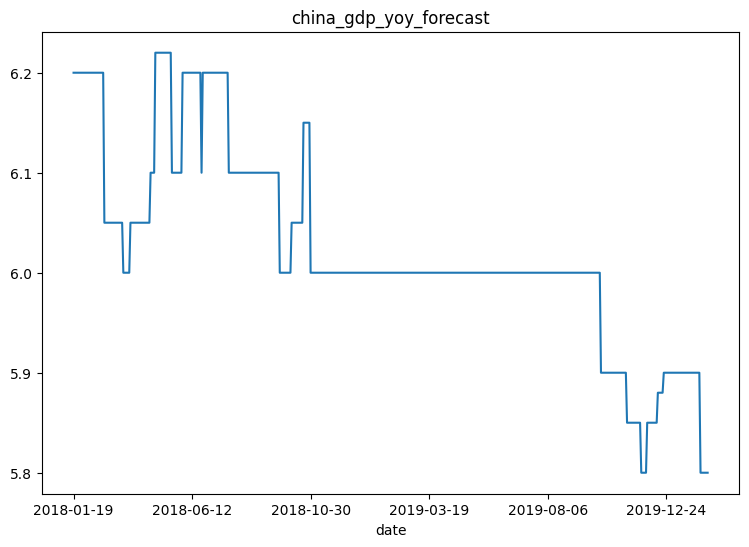

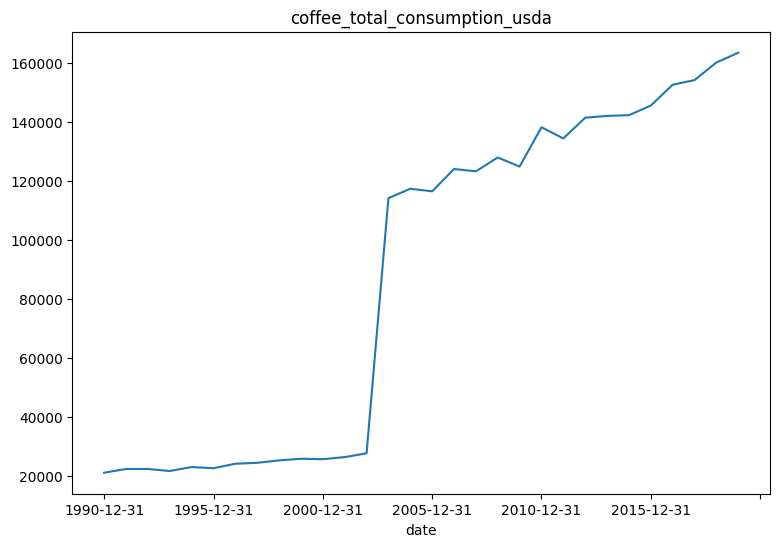

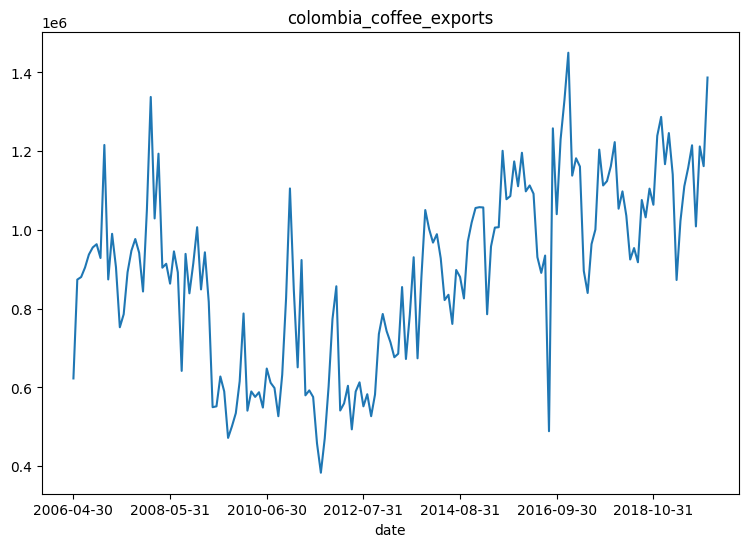

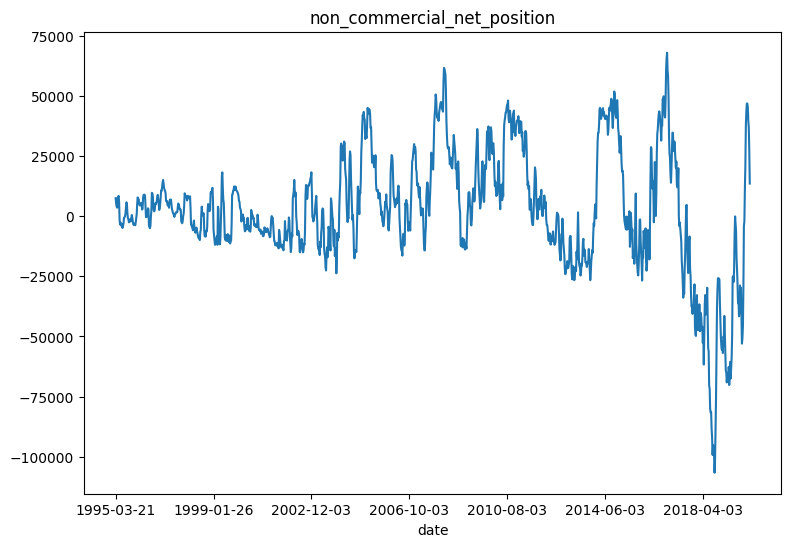

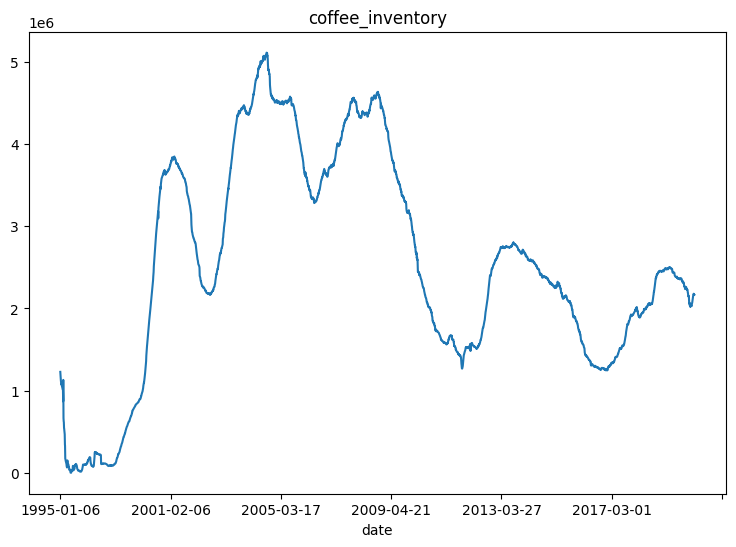

In [74]:
# First, there are some blank graph because of annual data so we'll remove NA data from those 
columns = ['China_GDP', 'china_gdp_yoy_forecast', 'coffee_total_consumption_usda',
           'colombia_coffee_exports', 'non_commercial_net_position', 'coffee_inventory']

# iterate over the columns
for column in columns:
    # get the data for the column and drop NA values
    data = df[column].dropna()
    
    # plot the data
    data.plot(figsize=(9,6), title=column)
    plt.show()

<AxesSubplot: title={'center': 'Coffee nearby price'}, xlabel='date'>

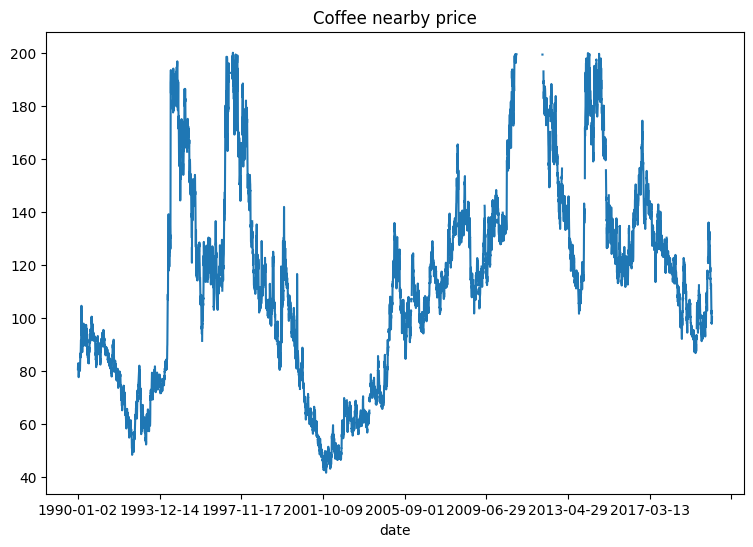

In [75]:
# Secondly we can see an issue with one data that we'll correct as follow
for i in range (len(df)):
    if(df['coffee_nearby'][i] > 200):
        df['coffee_nearby'][i] = df['coffee_nearby'][i-1]
df['coffee_nearby'].plot(figsize=(9,6), title='Coffee nearby price')

In [76]:
# Calculate the corraltion between each variables to see if all variables are relevant or not
correlation = df.corr()
print(correlation)
# From the result we got and thanks to the graph above, we have decided not to use the variables : china_gdp_yoy_forecast, coffee_total_consumption_usda, China_GDP, non_commercial_net_position and colombia_coffee_exports
# It makes sens because China don't drink coffee
# The others do not seem to have any interest

id_variable                    china_gdp_yoy_forecast  coffee_inventory  \
id_variable                                                               
china_gdp_yoy_forecast                       1.000000         -0.348577   
coffee_inventory                            -0.348577          1.000000   
coffee_nearby                                0.233818         -0.358699   
coffee_total_consumption_usda               -1.000000          0.690671   
colombia_coffee_exports                     -0.621187         -0.098297   
crude_nearby                                 0.600406          0.268929   
non_commercial_net_position                 -0.537032          0.127909   
sugar_nearby                                -0.354621         -0.186672   
vix_index                                    0.060901          0.002674   
dxy                                         -0.636626         -0.226288   
China_GDP                                   -1.000000          0.358395   
treasury_yield           

In [77]:
# Hence we remove the variables not used
df = df.drop('china_gdp_yoy_forecast', axis=1)
df = df.drop('coffee_total_consumption_usda', axis=1)
df = df.drop('China_GDP', axis=1)
df = df.drop('non_commercial_net_position', axis=1)
df = df.drop('colombia_coffee_exports', axis=1)
print(df)

id_variable  coffee_inventory  coffee_nearby  crude_nearby  sugar_nearby  \
date                                                                       
1990-01-02                NaN          80.56         22.89         13.02   
1990-01-03                NaN          81.75         23.68         14.22   
1990-01-04                NaN          82.48         23.41         14.17   
1990-01-05                NaN          81.16         23.08         14.16   
1990-01-08                NaN          81.38         21.62         14.06   
...                       ...            ...           ...           ...   
2020-02-05          2166495.0          97.75         50.75         14.73   
2020-02-06          2166185.0          98.15         50.95         14.74   
2020-02-07          2164799.0          98.35         50.32         14.92   
2020-02-10          2166601.0         100.30         49.57         15.04   
2020-02-11                NaN            NaN         49.97           NaN   

id_variable

In [78]:
# Removing NA
df = df.dropna()
df_week = df.reset_index()
# Changing date from daily to weekly 
df_week['date'] = pd.to_datetime(df_week['date'])
# Convert the 'date' column to the week format
df_week['week'] = df_week['date'].dt.to_period('W')

In [79]:
# Group the data by week and compute the mean price for each week

# Create a list of columns to group by and calculate the mean for each week
columns = ['coffee_nearby', 'sugar_nearby', 'crude_nearby', 'vix_index', 'coffee_inventory', 'dxy', 'treasury_yield']

# Initialize an empty list to store the resulting DataFrames
weekly_prices_list = []

# Iterate over the columns
for column in columns:
    # Group the data by week and calculate the mean for each column
    weekly_prices = df_week.groupby('week')[column].mean()

    # Reset the index and rename the 'price' column
    weekly_prices = weekly_prices.reset_index().rename(columns={column: column})

    # Append the resulting DataFrame to the list
    weekly_prices_list.append(weekly_prices)

# Merge all the DataFrames in the list into a single DataFrame
df_weekly = weekly_prices_list[0]
for weekly_prices in weekly_prices_list[1:]:
    df_weekly = pd.merge(df_weekly, weekly_prices, on='week')

In [80]:
# Keep weekly data and putting it as the index of the dataframe
df_weekly['week'] = df_weekly['week'].astype(str)
df_weekly['week'] = df_weekly['week'].str.slice(0, 10)
df_weekly['week'] = pd.to_datetime(df_weekly['week'])
df_weekly.set_index('week', inplace=True)

In [81]:
# Linear regression with few variables

# Split the data into training and test sets
# We decide to put only this 3 variables because they gave us the better R2
X_train, X_test, y_train, y_test = train_test_split(df_weekly[['sugar_nearby','dxy','coffee_inventory']], df_weekly['coffee_nearby'], test_size=0.2, shuffle=False)

# Create a linear regression model
regression = LinearRegression()
# Train the model using the training data
regression.fit(X_train, y_train)
# Make predictions on the test data
y_pred = regression.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
df_pred = y_test.to_frame()
df_pred['pred'] = y_pred.tolist()
print('Mean Squared Error :', mse)
print('R2 :', r2)

Mean Squared Error : 90.1564698630854
R2 : 0.6851592361237173


In [82]:
# Polynomial regression with few variables

# Split the data into training and test sets
# We decide to put only this 3 variables because they gave us the better R2
X_train, X_test, y_train, y_test = train_test_split(df_weekly[['sugar_nearby','dxy']], df_weekly['coffee_nearby'], test_size=0.2, shuffle=False)

# Create a plynomial regression model
poly_features = PolynomialFeatures(degree=2)
X_train_poly = poly_features.fit_transform(X_train)
X_test_poly = poly_features.fit_transform(X_test)
model = LinearRegression()
# Train the model using the training data
model.fit(X_train_poly, y_train)
# Make predictions on the test data
y_pred = model.predict(X_test_poly)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Polynomial model :')
print('-> Mean Squared Error :', mse)
print('-> R2 :', r2)

# Random forest with few variables

# Create a random forest model
rf = RandomForestRegressor(max_depth=10, random_state=2)
# Train the model using the training data
rf.fit(X_train, y_train)
# Make predictions on the test data
y_pred = rf.predict(X_test)

# Evaluate the model's performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print('Random Forest :')
print('-> Mean Squared Error :', mse)
print('-> R2 :', r2)

# With the polynomial regression and the random forest, we got prediction with a negative R2 which means that they are incorrect
# With the simple linear regression, we got a R2 of 0.685 which is pretty good so we will use it for our trading strategy

Polynomial model :
-> Mean Squared Error : 418.8945787527069
-> R2 : -0.4628466416045458
Random Forest :
-> Mean Squared Error : 1552.729298451571
-> R2 : -4.42237821822416


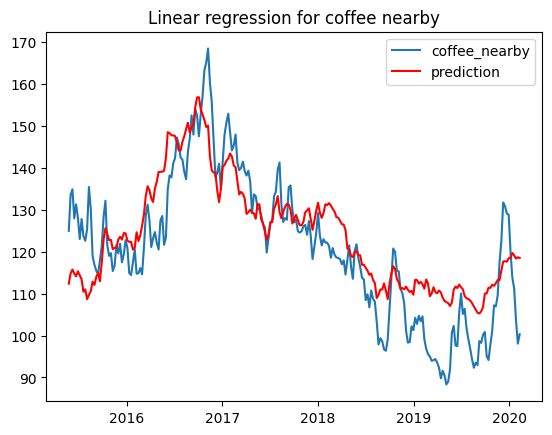

In [83]:
# Visualising the test set results in a scatter plot
plt.plot(df_pred['coffee_nearby'], label='coffee_nearby')
plt.plot(df_pred['pred'], label='prediction', color='red')
plt.title('Linear regression for coffee nearby')
plt.legend()
plt.show()

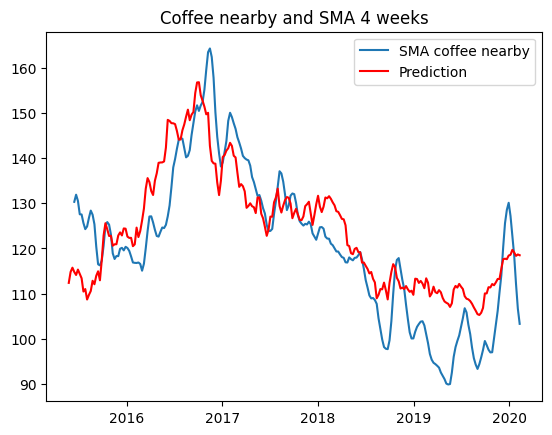

In [84]:
# Adding the SMA of coffee nearby and prediction
df_pred['SMA_coffee_nearby'] = df_pred['coffee_nearby'].rolling(4).mean()
df_pred['SMA_prediction'] = df_pred['pred'].rolling(4).mean()
plt.plot(df_pred['SMA_coffee_nearby'], label='SMA coffee nearby')
plt.plot(df_pred['pred'], label='Prediction', color='red')
plt.title('Coffee nearby and SMA 4 weeks')
plt.legend()
plt.show()

In [85]:
# Trading strategy depending on the Linear Regression
# Dropping NA from df_pred to get rid off the row with NA created with moving average
df_pred = df_pred.dropna()

positions = []
PnL = []

money = 100
# iterate over the rows of the dataframe
for _, row in df_pred.iterrows():
    # calculate the spread between the predicted price and the moving average
    spread = row['pred'] - row['SMA_coffee_nearby']

    if(positions):
        # long position, selling the contract to close position
        if(positions[-1] > 0):
            money += row['coffee_nearby'] * positions[-1]
        # short position, buying the contract to close position
        else:
            money += row['coffee_nearby'] * positions[-1]

    #print('Money :', money)
    PnL.append(money-100)
    # take a long position if the spread is positive, and a short position if the spread is negative
    if(spread > 0):
        position = money / row['coffee_nearby']
        money -= position*row['coffee_nearby'] # buying as much contract as possible with the money remaining
    else:
        position = -money/row['coffee_nearby']
        money += position*-row['coffee_nearby'] # selling as much contract as possible with the money remaining
    # append the position to the list of positions
    positions.append(position)

df_pred = df_pred.assign(PnL=PnL)
print('Final PnL :', "{:.3f}".format(PnL[-1]))
print('Returns :', "{:.3f}".format(PnL[-1]-100/100),'%')


Final PnL : 371.380
Returns : 370.380 %


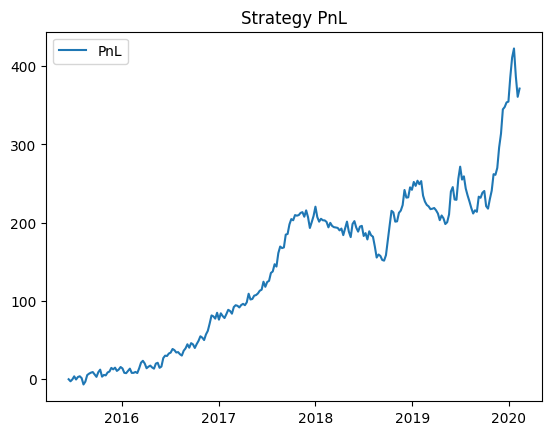

In [86]:
# Plotting the P&L of the strategy
plt.plot(df_pred['PnL'], label='PnL')
plt.title('Strategy PnL')
plt.legend()
plt.show()

Our trading strategy has achieved a return of 370% which is an outstanding result. It is important to note that this level of return is not typical and may not be sustainable in the long term. It is always important to carefully consider the risks and potential rewards of any investment strategy and to diversify your portfolio to mitigate risk. It is also important to be aware of market conditions and to have a solid understanding of the strategies you are using in order to make informed decisions. However, the 370% return we have seen so far is certainly impressive and we are excited to see what the future holds.

We first retrieved our data, then we analyzed it, in the third step we arranged it to put it into the same dataframe. In the fourth step, we studied the correlation and the link between each variable graphically. In the fifth step, we converted the data into weekly data and finally we designed a trading algorithm based on a linear regression between coffee_nearby, sugar_nearby, dxy and coffee_inventory.